In [1]:
from ghostnet.ghost_net import ghost_net
# from keras.datasets import mnist
import pandas as pd
import numpy as np
import torch
from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn,optim
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import SimpleITK as sitk
from sklearn.decomposition import PCA
from keras.preprocessing.image import ImageDataGenerator
import os

# 检验GPU是否可用
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

True
cuda:0


In [2]:
def dataLoad(path1, path2):
    paths1 = os.listdir(path1)
    paths2 = os.listdir(path2)
    dataset = []
    labelset = []
    
    for file in paths1:
        if file.find('mhd')>=0:
            filepath = os.path.join(path1, file)
            data = sitk.GetArrayFromImage(sitk.ReadImage(filepath))
            data = data.reshape((1,256,256))
            dataset.append(data)
            labelset.append(1)
            
    for file in paths2:
        if file.find('mhd')>=0:
            filepath = os.path.join(path2, file)
            data = sitk.GetArrayFromImage(sitk.ReadImage(filepath))
            data = data.reshape((1,256,256))
            dataset.append(data)
            labelset.append(0)
        
    dataset = np.array(dataset)
    labelset = np.array(labelset)
    return dataset, labelset

In [3]:
train_data, train_label = dataLoad('Training/Diseased', 'Training/Healthy')
test_data, test_label = dataLoad('Testing1/Diseased', 'Testing1/Healthy')

print(train_data.shape)
print(test_data.shape)

train_data = train_data.reshape((378,256,256,1))
print(train_data.shape)


(378, 1, 256, 256)
(50, 1, 256, 256)
(378, 256, 256, 1)


In [4]:
train_data = train_data.reshape((378,1,256,256))
test_data = test_data.reshape((-1,1,256,256))
train_data = torch.FloatTensor(train_data)
test_data = torch.FloatTensor(test_data)
train_label = torch.LongTensor(train_label)
test_label = torch.LongTensor(test_label)

In [5]:
test_label.shape

torch.Size([50])

In [6]:
class MyDataset(Dataset):
    
    # 初始化
    def __init__(self, pics, lable):
        # 读入数据
        self.data = pics
        self.lable = lable
        
    # 返回df的长度
    def __len__(self):
        return len(self.data)
    
    # 获取第idx+1列的数据
    def __getitem__(self, idx):
        return self.data[idx],self.lable[idx]

In [7]:
my_dataset_train = MyDataset(train_data, train_label)
my_dataset_test = MyDataset(test_data, test_label)
train_loader = DataLoader(dataset = my_dataset_train, batch_size = 8, shuffle = True)
test_loader = DataLoader(dataset = my_dataset_test, batch_size = 8, shuffle = True)

In [8]:
model = ghost_net(width_mult=1.0,num_classes=2).to(device)
# model = Net().to(device)
# optimizer = optim.Adam(model.parameters(),lr=0.001)  # 优化方式为mini-batch momentum-SGD，并采用L2正则化（权重衰减）
weights = torch.Tensor([2,1]).to(device) #
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss(weight=weights)

In [12]:
num_epochs = 10
n_total_steps = len(train_loader)
LossList = [] # 记录每一个epoch的loss
AccuryList = [] # 每一个epoch的accury
for epoch in range(num_epochs):
    # -------
    # 开始训练
    # -------
    model.train() # 切换为训练模型
    totalLoss = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device) # 图片大小转换
        labels = labels.to(device)
        # 正向传播以及损失的求取
        outputs = model(images)
#         labels = labels.squeeze(1)
        loss = criterion(outputs, labels)
        totalLoss = totalLoss + loss.item()
        # 反向传播
        optimizer.zero_grad() # 梯度清空
        loss.backward() # 反向传播
        optimizer.step() # 权重更新
        if (i+1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, n_total_steps, totalLoss/(i+1)))
    LossList.append(totalLoss/(i+1))
    # ---------
    # 开始测试
    # ---------
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        ones = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1) # 预测的结果
            ones += predicted.sum()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print("判断为1的总数为:", ones.item())
        acc = 100.0 * correct / total # 在测试集上总的准确率
        AccuryList.append(acc)
        print('Accuracy of the network on the {} test images: {} %'.format(total, acc))
print("模型训练完成")

In [9]:
model = torch.load('GhostNet.pkl')

In [10]:
'''
将label转换为 ROC 需要准备的格式
'''
test_y = np.zeros((50,2))
for i, label in enumerate(test_label):
    test_y[i,label] = 1

In [11]:
predicted_digit = model(test_data.cuda())

In [12]:
_, predicted = torch.max(predicted_digit, 1)

In [18]:
from sklearn.metrics import confusion_matrix
C = confusion_matrix(test_label, predicted.cpu())

Text(30.5, 0.5, 'true')

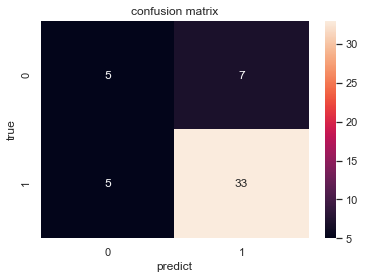

In [19]:
import seaborn as sns
sns.set()
f,ax=plt.subplots()
sns.heatmap(C,annot=True,ax=ax) #画热力图
ax.set_title('confusion matrix') #标题
ax.set_xlabel('predict') #x轴
ax.set_ylabel('true') #y轴

In [22]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
test_y = test_y
predicted = predicted_digit.cpu().detach().numpy()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(test_y[:, i], predicted[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_y.ravel(), predicted.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [23]:
roc_auc

{0: 0.7719298245614035, 1: 0.7828947368421052, 'micro': 0.8672}

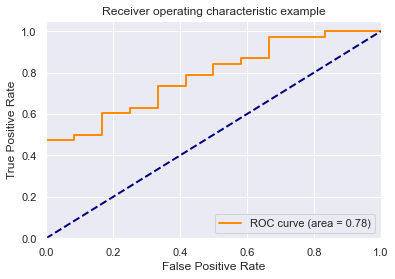

In [24]:
plt.figure()
lw = 2
plt.plot(
    fpr[1],
    tpr[1],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[1],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

<ipython-input-25-c1f3bd1088dc>:11: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


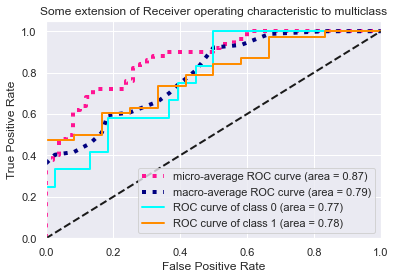

In [25]:
from scipy import interp
from itertools import cycle

# First aggregate all false positive rates
n_classes = 2
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

In [37]:
torch.save(model, 'GhostNet.pkl') 